# <font color="#006d77">**Forecasting with Exponential Smoothing: From Simple to Holt-Winters Method**</font>

---

<font color="#ff6600"><h3>Overview</h3></font>

This notebook covers different types of **Exponential Smoothing** techniques for time series forecasting:

1. **Simple Exponential Smoothing (SES)**  
2. **Double Exponential Smoothing (Holt’s Method)**  
3. **Triple Exponential Smoothing (Holt-Winters Method)**

---

<font color="#ff6600"><h3>Objectives</h3></font>

- Understand the core idea of exponential smoothing  
- Learn how each method builds on the previous:
  - SES handles **level**
  - Holt’s method handles **level + trend**
  - Holt-Winters method handles **level + trend + seasonality**
- Apply Holt-Winters method to forecast daily revenue  
- Visualize and interpret the forecast results

---

<font color="#ff6600"><h3>Dataset</h3></font>

We will use a **daily revenue time series**, where each row corresponds to a revenue value recorded on a specific date. This data will help us:

- Visualize time-based patterns  
- Train smoothing models  
- Forecast future values  

---

<font color="#004d4d"><h2>Introduction to Exponential Smoothing</h2></font>

Exponential Smoothing is a classic and widely used **time series forecasting** technique that originated in the **1950s**. Robert G. Brown introduced it in **1956**, and it was further developed by Charles C. Holt (1957) and Peter Winters (1960).

---

<font color="#ff6600"><h3>Why the "Exponential" in Exponential Smoothing?</h3></font>

The method assigns weights to past observations that **decrease exponentially** as the observations get older:

- Most recent data points have the **highest weight**
- Older data points’ influence **decays geometrically** with time
- This gives the method a “memory” that prioritizes **recent changes**, while still considering historical patterns

---

<font color="#ff6600"><h3>Position Between Naïve and Mean Forecasting</h3></font>

- **Naïve forecast**: Uses only the most recent observation to project the next value  
- **Mean forecast**: Uses the average of all past observations  
- **Exponential Smoothing**: Strikes a balance between these two by:
  - Using **all past data**
  - Giving **more weight to recent values**
  - Allowing forecasts to be **more responsive** to recent changes

---

<font color="#ff6600"><h3>Key Strengths</h3></font>

- **Computationally lightweight**: Requires only the previous forecast and the latest data point  
- **Highly adaptable**, with extensions to handle:
  - **Level only** → Simple Exponential Smoothing (SES)
  - **Level + Trend** → Holt’s Linear Trend Method
  - **Level + Trend + Seasonality** → Holt–Winters Method (Triple Exponential Smoothing)

---

<font color="#ff6600"><h3>Sources & References</h3></font>

- [InfluxData Beginner’s Guide](https://www.influxdata.com/blog/exponential-smoothing-beginners-guide)  
- [Valeman Medium Article on Brown’s Origins](https://valeman.medium.com/robert-g-browns-exponential-smoothing-origins-development-and-legacy-e23dd8cca159)p

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [ ]:

daily_revenue_df = pd.read_csv("/content/daily_revenue.csv", index_col = "date", parse_dates = True)
daily_revenue_df.head()

,revenue,discount_rate,coupon_rate
date,,,
1/1/2018,"6,270,839",34.27%,1.09%
2/1/2018,"8,922,076",30.87%,1.08%
3/1/2018,"8,446,101",28.11%,1.01%
4/1/2018,"7,785,798",27.32%,0.96%
5/1/2018,"6,375,303",25.70%,0.90%


In [ ]:
# Display information about the DataFrame, including data types and non-null counts
daily_revenue_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1795 entries, 1/1/2018 to 30/11/2022
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   revenue        1795 non-null   object
 1   discount_rate  1795 non-null   object
 2   coupon_rate    1795 non-null   object
dtypes: object(3)
memory usage: 56.1+ KB


In [ ]:
daily_revenue_df.isnull().sum()

,0
revenue,0
discount_rate,0
coupon_rate,0


In [ ]:
len(daily_revenue_df['revenue'])

1795

# <font color="#006d77">**Data Pre-processing** </font>

In [ ]:
# Remove comma from column 'complaints' and transform the values into float
daily_revenue_df['revenue'] = daily_revenue_df['revenue'].str.replace(',', '').astype(int)
daily_revenue_df.head()

,revenue,discount_rate,coupon_rate
date,,,
1/1/2018,6270839,34.27%,1.09%
2/1/2018,8922076,30.87%,1.08%
3/1/2018,8446101,28.11%,1.01%
4/1/2018,7785798,27.32%,0.96%
5/1/2018,6375303,25.70%,0.90%


In [ ]:
daily_revenue_df.index = pd.to_datetime(daily_revenue_df.index,dayfirst=True)

# <font color="#006d77">**Exploratory Data Analysis** </font>

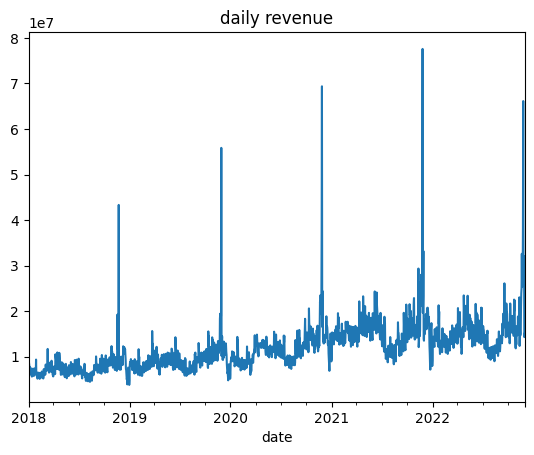

In [ ]:
# Plot the weekly complaint values
daily_revenue_df['revenue'].plot(title = 'daily revenue')
plt.show()

### <font color="#ff6600">Observation</font>:
- From the above graph a clear yearly seasonal pattern and an increading upward trend is evident

# <font color="#006d77">**Seasonal Decomposition** </font>

This reveals the structure of the series by separating it into three main components:

### Components of Time Series

- **Trend**  
  The long-term progression of the series — it shows the overall direction (increasing, decreasing, or stable) over time.

- **Seasonal**  
  The repeating short-term cycle or pattern at fixed intervals, such as daily, weekly, monthly, or quarterly.

- **Residual (Irregular or Noise)**  
  The random variation or "leftover" part of the data after removing both trend and seasonal components.

---

### Things to Consider Before Performing Seasonal Decomposition

##### 1. Model Selection

Before decomposing the series, it's important to choose the correct model type:

- **Additive Model**: Use when the seasonal fluctuations are roughly constant over time.
- **Multiplicative Model**: Use when the seasonal variation increases or decreases with the level of the trend.

##### 2. Identify the Seasonality Period

You need to determine the correct **seasonal period** (e.g., 12 for monthly seasonality, 365 for yearly seasonality in daily data). This can be guided by:

- Domain knowledge  
- Visual inspection of time series plots  
- Autocorrelation and partial autocorrelation plots  
- Spectral analysis

---

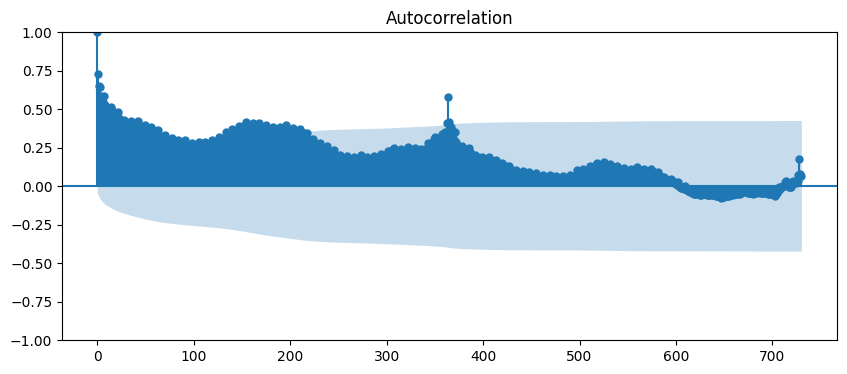

In [ ]:
# Plotting the autocorrelation to determine seasonal period.
fig, ax = plt.subplots(figsize = (10,4))
plot_acf(daily_revenue_df['revenue'], lags = 730, ax = ax)
plt.show()

### <font color="#ff6600">Observation</font> :
  Repeaitng spikes after every 365 interval indicate repeating seasonal patterns.

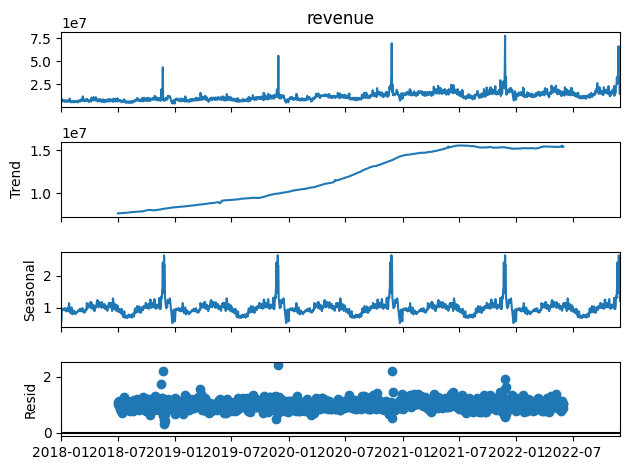

In [ ]:

# In our case, we use: #model=multiplicative and period= 365
# This is because our daily revenue dataset exhibits **yearly seasonality** which is increasing with the trend, as observed in the earlier visualization and also in the ACF plot
result = seasonal_decompose(daily_revenue_df['revenue'],model = 'mul',period = 365)

result.plot()
plt.show()



# <font color="#006d77">**Data Preparation for Modeling** </font>


###Performing Train Test Split


- Train: all data except last 365 samples
- Test: contains last 365 samples


-  We will train the data on all the samples except for last 365 days and after modeling we will do predictions on the test data

In [ ]:
len(daily_revenue_df)

1795

In [ ]:


n_samples = 365
train, test = daily_revenue_df.iloc[:-n_samples,0], daily_revenue_df.iloc[-n_samples:, 0 ]
test.head()

,revenue
date,
2021-12-01,13526425
2021-12-02,16592762
2021-12-03,14928804
2021-12-04,15696804
2021-12-05,18117228


# <font color="#006d77">**Lets Begin with Modeling by Simple Exponential Smoothing** </font>

Simple Exponential Smoothing (SES) is a basic yet powerful method for forecasting time series data that shows **no clear trend or seasonality**. It works by assigning exponentially decreasing weights to past observations, emphasizing more recent data.

---


This method uses a single parameter, **alpha (α)**, known as the **smoothing factor**. It controls how much weight is placed on the most recent observation versus the historical average.

- If **α** is close to 1, the model gives more importance to recent data (fast adaptation).
- If **α** is close to 0, the model smooths more slowly, giving more weight to past observations.

The smoothing factor **α** typically ranges between **0 and 1**.

---


## Mathematical Formula

The update rule for Simple Exponential Smoothing is given by:

\[
s_t = \alpha x_t + (1 - \alpha) s_{t-1}
\]

Or equivalently:

\[
s_t = s_{t-1} + \alpha(x_t - s_{t-1})
\]

Where:

- \( s_t \) = Smoothed statistic at time \( t \)  
- \( x_t \) = Actual value at time \( t \)  
- \( s_{t-1} \) = Smoothed statistic at time \( t-1 \)  
- \( \alpha \) = Smoothing factor ( \( 0 < \alpha < 1 \) )

---

## Intuition

Think of SES as a weighted moving average where **weights decay exponentially** into the past. It’s a middle ground between:

- **Naive forecasting**: using only the most recent value.
- **Simple averaging**: using the mean of all past values equally.

---

In [ ]:

SES_model = SimpleExpSmoothing(train).fit()

ses_model_predictions = SES_model.forecast(len(test))

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


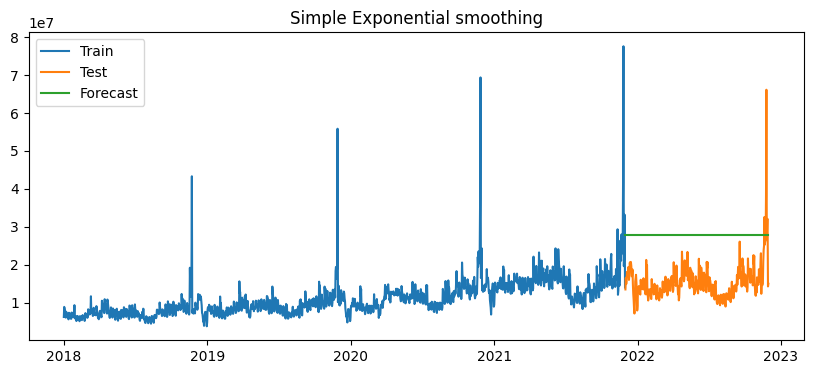

In [ ]:

plt.figure(figsize = (10,4))

plt.plot(train, label = 'Train')
plt.plot(test, label = 'Test')
plt.plot(ses_model_predictions, label = "Forecast")
plt.title("Simple Exponential smoothing")
plt.legend()
plt.show()


# <font color="#006d77">**Next we are implementing Double Exponential Smoothing (Holt's Linear Smoothing)** </font>

Double Exponential Smoothing, also known as **Holt’s Trend Method**, **Second-Order Smoothing**, or **Holt’s Linear Smoothing**, extends Simple Exponential Smoothing to capture data with a **trend**. It is used when the time series data exhibits a trend but **not seasonality**.

---

## Purpose

The core idea behind Double Exponential Smoothing is to model both the **level** and the **trend** of the series:

- The **level** is the smoothed estimate of the series.
- The **trend** captures the increasing or decreasing movement over time.

---

## Parameters

This method introduces an additional parameter:

- **Alpha (α)**: Smoothing factor for the level (same as in Simple Exponential Smoothing).
- **Beta (β)**: Smoothing factor for the trend. Controls how quickly the trend component is updated over time.

Both α and β range between 0 and 1.

---

## Intuition

Simple Exponential Smoothing works well when data has no trend, but it falls short when the data shows a consistent **upward or downward movement** over time.

Double Exponential Smoothing solves this by:

- Keeping track of **how fast the series is changing** using a trend component.
- Adjusting the forecast not just based on the most recent value, but also based on how the series has been increasing or decreasing.
- Using two smoothing equations: one for the level and one for the trend, so it can adapt as the trend grows stronger or weaker.

This means the model doesn't just "follow" the data—it learns and **projects the direction** the data is going.

---

## When to Use

- Data contains a **trend**, but **no seasonality**.
- Useful for **short- to medium-term forecasting** where trend behavior is observed.

---

## Mathematical Formulas

Let:

- \( s_t \): Smoothed value (level) at time \( t \)
- \( b_t \): Estimated trend at time \( t \)
- \( x_t \): Actual observation at time \( t \)

### Update equations:

\[
s_t = \alpha x_t + (1 - \alpha)(s_{t-1} + b_{t-1})
\]

\[
b_t = \beta (s_t - s_{t-1}) + (1 - \beta) b_{t-1}
\]

---

### Explanation of Terms

- \( \alpha \): Controls how much weight is given to the latest observation versus the past level plus trend.
- \( \beta \): Controls how quickly the trend component is updated.
- \( s_t \): Represents the smoothed value (forecasted level).
- \( b_t \): Represents the best estimate of the trend at time \( t \).

---



Double Exponential Smoothing is ideal for time series data that shows a **trend but no seasonality**. It learns both the current level and the trend of the data and uses both to make accurate forecasts.

In [ ]:

DES_model = ExponentialSmoothing(train,trend = 'mul',seasonal = None).fit()
des_model_predictions = DES_model.forecast(len(test))
des_model_predictions


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:85: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_numdiff.py:596: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0


,0
2021-12-01,2.609419e+07
2021-12-02,2.588051e+07
2021-12-03,2.566858e+07
2021-12-04,2.545838e+07
2021-12-05,2.524991e+07
...,...
2022-11-26,1.352041e+06
2022-11-27,1.340969e+06
2022-11-28,1.329988e+06
2022-11-29,1.319097e+06


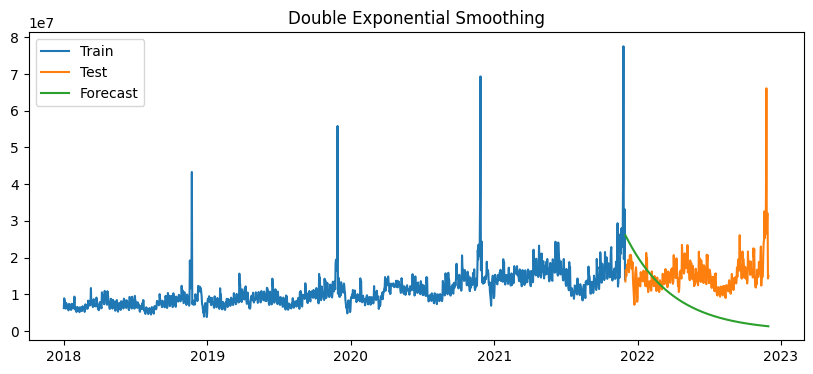

In [ ]:

plt.figure(figsize = (10,4))
plt.plot(train, label = 'Train')
plt.plot(test, label = 'Test')
plt.plot(des_model_predictions, label = "Forecast")
plt.title("Double Exponential Smoothing")
plt.legend()
plt.show()

# <font color="#006d77">**Holt-Winters’ exponential smoothing(Triple Exponential Smoothing)** </font>

This is an extension of exponential smoothing that captures **both trend and seasonality** in time series data.

This method is ideal when your data exhibits:

- A **linear trend**, and  
- A **seasonal pattern** (e.g., yearly, monthly, weekly fluctuations).

---

## Overview

Triple exponential smoothing applies exponential smoothing **three times**:

1. **Level smoothing** – to capture the baseline value
2. **Trend smoothing** – to account for upward/downward movement
3. **Seasonal smoothing** – to model repeating cycles

It introduces a **new parameter**, gamma (γ), which controls the impact of the seasonal component.

---

## Types of Holt-Winters Models

There are two types, depending on the nature of the seasonality:

- **Additive Seasonality** – Use when seasonal variations are roughly constant over time.
- **Multiplicative Seasonality** – Use when seasonal variations increase or decrease proportionally with the level.

---

## Parameters

Triple exponential smoothing uses **three parameters**:

- \( \alpha \): Level smoothing factor (intercept)
- \( \beta \): Trend smoothing factor
- \( \gamma \): Seasonal smoothing factor

All three parameters lie between **0 and 1**.

---

## Mathematical Formulation

Let:

- \( s_t \): Smoothed level at time \( t \)
- \( b_t \): Trend component at time \( t \)
- \( c_t \): Seasonal component at time \( t \)
- \( x_t \): Actual observation at time \( t \)
- \( L \): Season length (e.g., 12 for monthly seasonality over a year)

### Initial condition:

\[
s_0 = x_0
\]

### Update equations (Multiplicative version shown):

\[
s_t = \alpha \left( \frac{x_t}{c_{t-L}} \right) + (1 - \alpha)(s_{t-1} + b_{t-1})
\]

\[
b_t = \beta (s_t - s_{t-1}) + (1 - \beta)b_{t-1}
\]

\[
c_t = \gamma \left( \frac{x_t}{s_t} \right) + (1 - \gamma)c_{t-L}
\]

---

## Explanation of Terms

- \( s_t \): Smoothed level (baseline estimate)
- \( b_t \): Best estimate of the trend
- \( c_t \): Seasonal component
- \( \alpha \): Controls weight on the new level observation
- \( \beta \): Controls how quickly the trend updates
- \( \gamma \): Controls how quickly the seasonality adjusts

---



- **Triple Exponential Smoothing** is the most sophisticated of the three smoothing techniques.
- It handles **level, trend, and seasonality** simultaneously.
- Requires more data and more computation, but provides **accurate forecasts** for time series with complex patterns.

> Next, we’ll implement the Holt-Winters  and apply it to our revenue dataset to perform time series forecasting.

In [ ]:

TES_model = ExponentialSmoothing(train,trend = 'mul',seasonal = "mul",seasonal_periods = 365).fit()

tes_model_predictions = TES_model.forecast(len(test))
tes_model_predictions


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


,0
2021-12-01,1.665330e+07
2021-12-02,1.380312e+07
2021-12-03,1.334726e+07
2021-12-04,1.339762e+07
2021-12-05,1.446078e+07
...,...
2022-11-26,5.544928e+07
2022-11-27,4.044769e+07
2022-11-28,3.175093e+07
2022-11-29,2.486729e+07


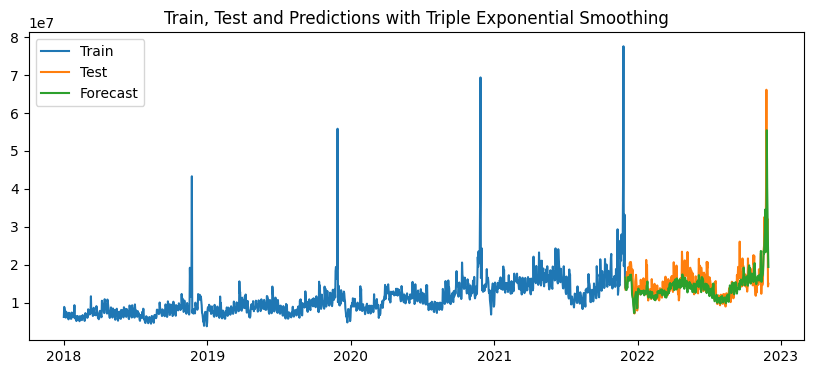

In [ ]:
# Set the size of the plot to 10 inches by 4 inches
plt.figure(figsize = (10,4))

# Plot train, test, and forecasts values
plt.plot(train, label = 'Train')
plt.plot(test, label = 'Test')
plt.plot(tes_model_predictions, label = "Forecast")

# add title and legend to the plot
plt.title("Train, Test and Predictions with Triple Exponential Smoothing")
plt.legend()
plt.show()

In [ ]:

rmse = mean_squared_error(test, tes_model_predictions)
mape = mean_absolute_percentage_error(test, tes_model_predictions)


print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {100 * mape:.2f} %")

RMSE: 13746925771359.20
MAPE: 13.47 %


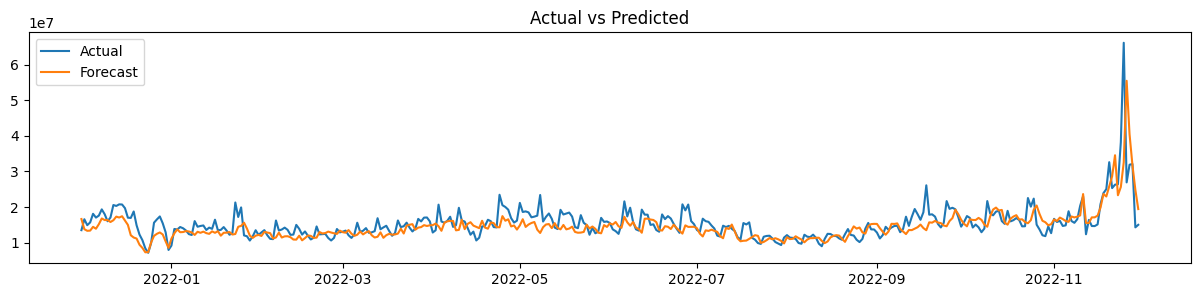

In [ ]:

plt.figure(figsize = (15,3))

plt.plot(test, label = 'Actual')
plt.plot(tes_model_predictions, label = "Forecast")
plt.title(f"Actual vs Predicted")
plt.legend()
plt.show()

### <font color="#ff6600">Final Take</font>


- As we progress from simple to triple exponential smoothing, each method captures more complexity — starting from level-only modeling, then incorporating trend, and finally accounting for seasonality.

- This progression leads to **increasingly accurate predictions**, especially for real-world time series where trends and seasonality play a significant role.

# <font color="#006d77">**Next we fit and  train the model on the entire data and make future predictions** </font>

In [ ]:

model = ExponentialSmoothing(daily_revenue_df.revenue,trend = 'mul',seasonal = "mul",seasonal_periods = 365).fit()
future_forecast = model.forecast(365)
future_forecast

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


,0
2022-12-01,1.627377e+07
2022-12-02,1.518865e+07
2022-12-03,1.430902e+07
2022-12-04,1.452563e+07
2022-12-05,1.605225e+07
...,...
2023-11-26,4.725705e+07
2023-11-27,3.918953e+07
2023-11-28,3.422469e+07
2023-11-29,2.237229e+07


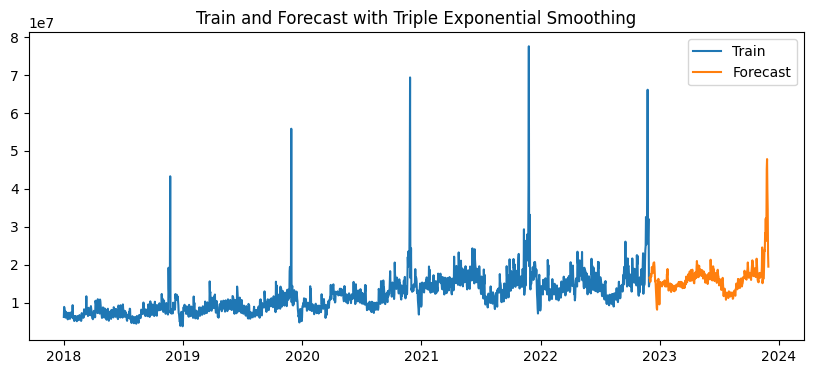

In [ ]:
# Set the size of the plot to 10 inches by 4 inches
plt.figure(figsize = (10,4))

# Plot train and forecast values
plt.plot(daily_revenue_df.revenue, label = 'Train')
plt.plot(future_forecast, label = "Future_Forecast")

# Add title and legend to the plot
plt.title("Future Forecast with Triple Exponential Smoothing")
plt.legend()
plt.show()